<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [ ]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [ ]:
!nvidia-smi

Mon Aug 31 03:42:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install cupy-cuda101

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [ ]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [ ]:
X = X.drop(['ID','WF','Set'],axis=1)

In [ ]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Fill NaN's

To avoid Exploding Gradients, here the NaN's are filled.

In [ ]:
X = X.fillna(method="ffill", axis=1) # ZOH
X = X.fillna(0)

In [ ]:
y = y.fillna(method="ffill", axis=1) # ZOH
y = y.fillna(0)

## Diff Data

## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [ ]:
directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))

directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
directions = directions.reset_index().drop('Time',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
X_columns = X.columns

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=X_columns)

In [ ]:
X = pd.concat([X,directions],axis=1)

In [ ]:
y = y.drop('ID',axis=1)
y = scaler.fit_transform(y)
y = pd.DataFrame(y)

In [ ]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Speed 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,V_10mLast_Month_Variance,cos_day,...,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max,Sin_Wind Direction 100m,Cos_Wind Direction 100m,Sin_Wind Direction 10m,Cos_Wind Direction 10m
0,0.228968,0.130650,-0.080167,0.046187,-0.652228,0.730090,-0.235387,-0.710735,-0.998463,-0.998463,-0.998463,-0.982084,-0.982084,-0.982084,-0.104511,-0.104511,-0.104511,-0.051678,-0.051678,-0.051678,-0.097700,-0.097700,-0.097700,0.004222,0.004222,0.004222,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0.010180,0.999948,0.015634,0.999878
1,0.243537,0.136909,-0.099786,0.062691,-0.648044,0.979522,-0.209145,-0.704468,-0.997542,-0.997542,-0.997542,-0.979261,-0.979261,-0.979261,-0.094891,-0.094891,-0.094891,-0.042877,-0.042877,-0.042877,-0.082122,-0.082122,-0.082122,0.018267,0.018267,0.018267,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.994934,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.010097,0.999949,0.018097,0.999836
2,0.238667,-0.050938,-0.091757,0.056334,-0.590239,0.283872,-0.340364,-0.707170,-0.997906,-0.997906,-0.997906,-0.980376,-0.980376,-0.980376,-0.098689,-0.098689,-0.098689,-0.046352,-0.046352,-0.046352,-0.088273,-0.088273,-0.088273,0.012721,0.012721,0.012721,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.924962,0.848259,-0.962208,-0.985599,-1.0,-0.965395,0.002650,0.999996,0.017125,0.999853
3,0.189158,-0.002548,-0.083169,0.017554,-0.654321,0.149650,-0.399844,-0.751810,-0.999176,-0.999176,-0.999176,-0.984269,-0.984269,-0.984269,-0.111956,-0.111956,-0.111956,-0.058490,-0.058490,-0.058490,-0.109757,-0.109757,-0.109757,-0.006647,-0.006647,-0.006647,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.77755,-0.795783,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0

In [ ]:
y

,0
0,-0.778768
1,-0.631774
2,-0.671863
3,-0.778768
4,-0.814402
...,...
6234,-0.768374
6235,-0.808463
6236,-0.867854
6237,-0.839644


In [ ]:
y.shape

(6239, 1)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [ ]:
n_steps = 60

In [ ]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [ ]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [ ]:
sample_X,sample_y = split_sequences(X.values,None,n_steps)

In [ ]:
n_features = sample_X.shape[2]

## Model

Here, a function to create the Model usin Keras is defined.

In [ ]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.1)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.1)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57, stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.1)(hidden_3)


  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [ ]:
input_shape = (n_steps,n_features)

In [ ]:
model = LSTM_Model(input_shape)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 60, 95)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 60, 128)              114688    
_________________________________________________________________
dropout (Dropout)            (1, 60, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 60, 87)               75168     
_________________________________________________________________
dropout_1 (Dropout)          (1, 60, 87)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 57)                   33060     
_________________________________________________________________
dropout_2 (Dropout)          (1, 57)                  

## Validation

In [ ]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

#n_rows = round(X.shape[0]/k_fold_splits)

In [ ]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    #train_index = train_index[-n_rows:]
    #test_index = test_index[-n_rows:]

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['root_mean_squared_error']).mean()
    val_score = np.array(history.history['val_root_mean_squared_error']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    preds = tf.cast(preds, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(y_test,preds)
    test_score = m.result().numpy()

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

Epoch 1/10
724/724 [==============================] - 8s 11ms/step - loss: 0.0845 - root_mean_squared_error: 0.2907 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 2/10
724/724 [==============================] - 7s 9ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 3/10
724/724 [==============================] - 7s 10ms/step - loss: 0.0816 - root_mean_squared_error: 0.2857 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/10
724/724 [==============================] - 7s 10ms/step - loss: 0.0785 - root_mean_squared_error: 0.2801 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1222
Epoch 5/10
724/724 [==============================] - 7s 10ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 6/10
724/724 [==============================] - 7s 9ms/step - loss: 0.0794 - root_mean_squared_error: 0.2817 - val_loss: 0.0111 - 

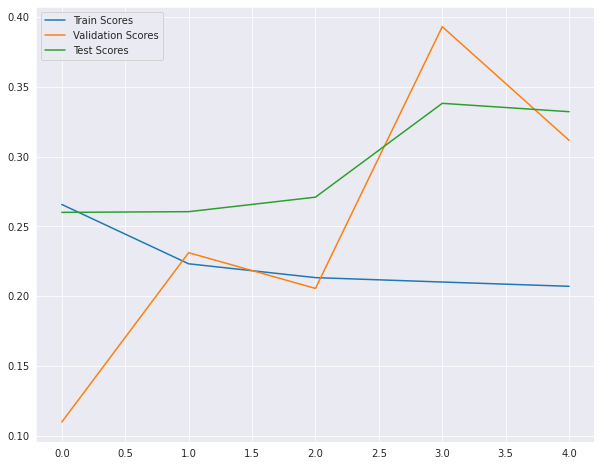

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_scores)),train_scores,label='Train Scores')
plt.plot(range(len(val_scores)),val_scores,label='Validation Scores')
plt.plot(range(len(test_scores)),test_scores,label='Test Scores')
plt.legend()

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)

In [ ]:
#X_train, y_train = X_train.iloc[-n_rows:],y_train.iloc[-n_rows:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [ ]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [ ]:
model = LSTM_Model(input_shape)

In [ ]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0590 - root_mean_squared_error: 0.2430 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969
Epoch 2/10
4619/4619 [==============================] - 45s 10ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2531
Epoch 3/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2716
Epoch 4/10
4619/4619 [==============================] - 45s 10ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3253
Epoch 5/10
4619/4619 [==============================] - 45s 10ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 6/10
4619/4619 [==============================] - 45s 10ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 -

In [ ]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [ ]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [ ]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [ ]:
metric_cnr(preds,y_holdout)

('CAPE', 31.5137094342074)

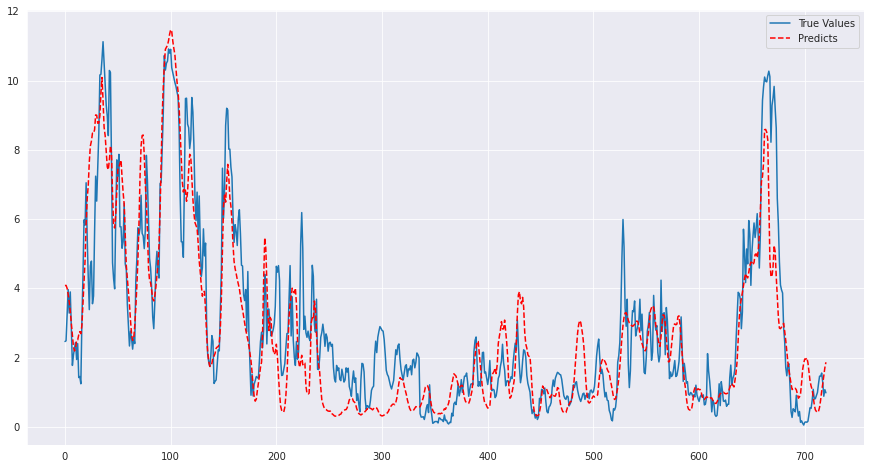

In [ ]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

In [ ]:
def preprocessing_net(full_X,full_y=None):
  processed_X = pd.DataFrame()
  processed_y = pd.DataFrame()
  for WF in full_X['WF'].unique():
    X = full_X[full_X['WF']==WF]

    scaler = MinMaxScaler(feature_range=(-1,1))

    if full_y is not None:
      y = full_y[full_y['ID'].isin(X['ID'])]
      y = y.fillna(method="ffill", axis=1) # ZOH
      y = y.fillna(0)
      y_saved_columns = y[['ID']].reset_index().drop('index',axis=1)
      y = y.drop('ID',axis=1)
      y = scaler.fit_transform(y)
      y = pd.DataFrame(y)
      y = pd.concat([y,y_saved_columns],axis=1)
      processed_y = pd.concat([processed_y,y])

    X_saved_columns = X[['ID','WF','Set','Month_Number']]
    X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
    X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

    # Fill NaN's
    X = X.fillna(method="ffill", axis=1) # ZOH
    X = X.fillna(0)

    # Scaling Data
    directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
    directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
    directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
    directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
    directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
    directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
    directions = directions.reset_index().drop('Time',axis=1)

    X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
    X_columns = X.columns

    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns=X_columns)
    X = pd.concat([X,directions],axis=1)
    X = pd.concat([X,X_saved_columns],axis=1)

    processed_X = pd.concat([processed_X,X])

  return processed_X,processed_y

In [ ]:
full_data,full_label = preprocessing_net(full_data,full_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
'''
final_preds = np.empty(0)
for WF in full_data['WF'].unique():
  X_WF = full_data[full_data['WF']==WF]
  full_X_train = X_WF[X_WF['Set']=='Train']

  last_train_month = full_X_train['Month_Number'].unique()[-1]
  full_X_train = full_X_train[full_X_train['Month_Number']==last_train_month]

  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]
  full_X_test = X_WF[X_WF['Set']=='Test']

  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_y_train = full_y_train.drop('ID',axis=1)


  X_train, y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  num_months = 8
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    X_test = X_test.drop(['ID','WF','Set'],axis=1)
    X_test, _ = split_sequences(X_test.values,None,n_steps)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    X_train = X_test
    y_train = pred
    WF_preds = np.append(WF_preds,pred)
    num_months = num_months + 1

  final_preds = np.append(final_preds,WF_preds)
  '''

'\nfinal_preds = np.empty(0)\nfor WF in full_data[\'WF\'].unique():\n  X_WF = full_data[full_data[\'WF\']==WF]\n  full_X_train = X_WF[X_WF[\'Set\']==\'Train\']\n\n  last_train_month = full_X_train[\'Month_Number\'].unique()[-1]\n  full_X_train = full_X_train[full_X_train[\'Month_Number\']==last_train_month]\n\n  full_y_train = full_label[full_label[\'ID\'].isin(full_X_train[\'ID\'])]\n  full_X_test = X_WF[X_WF[\'Set\']==\'Test\']\n\n  full_X_train = full_X_train.drop([\'ID\',\'WF\',\'Set\'],axis=1)\n  full_y_train = full_y_train.drop(\'ID\',axis=1)\n\n\n  X_train, y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)\n\n  num_months = 8\n  WF_preds = np.empty(0)\n  predicted_X_test = np.empty((0,60,95))\n  for month in full_X_test[\'Month_Number\'].unique():\n\n    print("Farm {} - Month {}".format(WF,month))\n\n    if month == 9:\n      X_test = full_X_test[full_X_test[\'Month_Number\']==month]\n      X_test_10 = full_X_test[full_X_test[\'Month_Number\']==10]\n   

In [ ]:
final_preds = np.empty(0)
for WF in full_data['WF'].unique():
  X_WF = full_data[full_data['WF']==WF]
  full_X_train = X_WF[X_WF['Set']=='Train']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]
  full_X_test = X_WF[X_WF['Set']=='Test']

  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_y_train = full_y_train.drop('ID',axis=1)


  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  num_months = 8
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/num_months, shuffle=False)

    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = scaler.inverse_transform(pred)
    pred = pred.reshape(pred.shape[0])

    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)
    num_months = num_months + 1

  final_preds = np.append(final_preds,WF_preds)

Farm WF1 - Month 1
Epoch 1/10
5407/5407 [==============================] - 53s 10ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011 - val_loss: 0.8095 - val_root_mean_squared_error: 0.8997
Epoch 2/10
5407/5407 [==============================] - 52s 10ms/step - loss: 0.2680 - root_mean_squared_error: 0.5177 - val_loss: 0.7258 - val_root_mean_squared_error: 0.8520
Epoch 3/10
5407/5407 [==============================] - 52s 10ms/step - loss: 0.2671 - root_mean_squared_error: 0.5168 - val_loss: 0.7420 - val_root_mean_squared_error: 0.8614
Epoch 4/10
5407/5407 [==============================] - 52s 10ms/step - loss: 0.2685 - root_mean_squared_error: 0.5182 - val_loss: 0.7192 - val_root_mean_squared_error: 0.8480
Farm WF1 - Month 2
Epoch 1/10
5781/5781 [==============================] - 57s 10ms/step - loss: 0.2456 - root_mean_squared_error: 0.4955 - val_loss: 5.9583 - val_root_mean_squared_error: 2.4410
Epoch 2/10
5781/5781 [==============================] - 55s 10ms/step - loss: 0.26

In [ ]:
final_preds.shape

(33343,)

In [ ]:
final_preds = scaler.inverse_transform(final_preds)

In [ ]:
final_preds = pd.DataFrame(final_preds,columns=['Production'])

In [ ]:
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

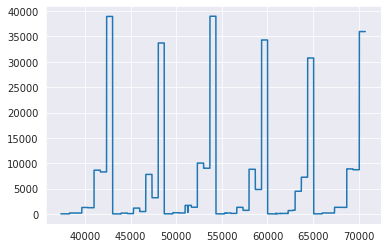

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>